# RoPE embeddings

In [26]:
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

In [89]:
def compute_dim_freqs(dim: int, theta: float = 10000.0):
    return 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))


def compute_freqs(dim: int, end: int, theta: float = 10000.0):
    freqs = compute_dim_freqs(dim, theta)
    t = torch.arange(end)
    freqs = torch.outer(t, freqs).float()
    return freqs


def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    # freqs: (end, dim // 2)
    freqs = compute_freqs(dim, end, theta)
    # freqs_cis: (end, dim // 2)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

In [75]:
def apply_rotary_emb_to_vector_as_complex(
    x: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> torch.Tensor:
    # x: (T, dim)
    # freqs_cis: (T, dim // 2)

    # reshape to complex numbers
    # (T, dim) -> (T, dim // 2, 2)
    x = x.float().reshape(*x.shape[:-1], -1, 2)
    # convert to complex numbers
    # (T, dim // 2, 2) -> (T, dim // 2)
    x_ = torch.view_as_complex(x)
    return x_ * freqs_cis
    # x_out = torch.view_as_real(x_ * freqs_cis)
    # return x_out.type_as(x)

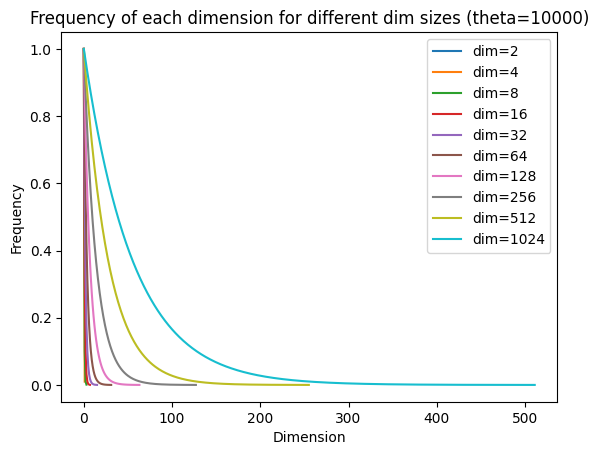

In [88]:
# Plot the freqs for various dims
theta = 10000
for dim_power in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dim = 2**dim_power
    freqs = compute_dim_freqs(dim, theta)
    plt.plot(freqs, label=f"dim={dim}")
plt.title("Frequency of each dimension for different dim sizes (theta=10000)")
plt.xlabel("Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.show()


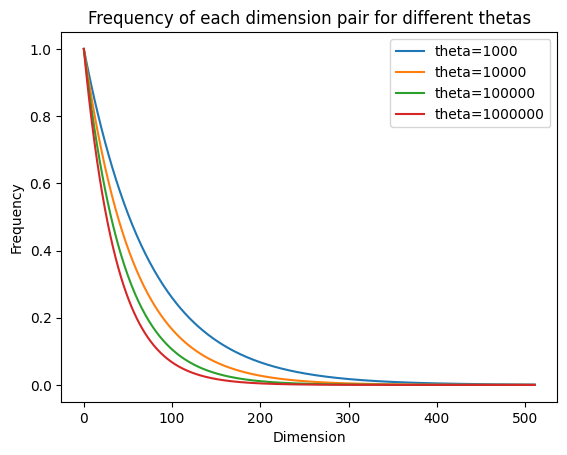

In [86]:
# Plot freqs for various theta for a given dim
dim = 1024
for theta in [1000, 10000, 100000, 1000000]:
    freqs = compute_dim_freqs(dim, theta)
    plt.plot(freqs, label=f"theta={theta}")
plt.title("Frequency of each dimension pair for different thetas")
plt.xlabel("Dimension")
plt.ylabel("Frequency")
plt.legend()
plt.show()


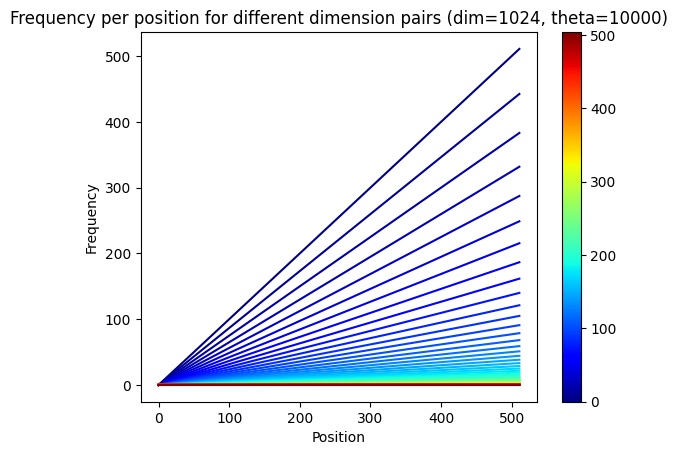

In [95]:
# plot the frequency per position for a given dim pair and theta
dim = 1024
theta = 10000
seq_len = 512
freqs = compute_freqs(dim, seq_len, theta)

# setup the normalization and the colormap
dims_to_plot = range(0, dim // 2, 8)
normalize = mcolors.Normalize(vmin=dims_to_plot[0], vmax=dims_to_plot[-1])
colormap = cm.jet

fig, ax = plt.subplots()

for d in dims_to_plot:
    ax.plot(freqs[:, d], label=f"dim={d}", color=colormap(normalize(d)))

ax.set_title(
    f"Frequency per position for different dimension pairs (dim={dim}, theta={theta})"
)
ax.set_xlabel("Position")
ax.set_ylabel("Frequency")

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(dims_to_plot)
fig.colorbar(scalarmappaple, ax=ax)

plt.show()


In [97]:
def convert_freqs_to_angles(freqs):
    mod_freqs = freqs % (2 * torch.pi)
    return torch.where(mod_freqs > torch.pi, mod_freqs - 2 * torch.pi, mod_freqs)

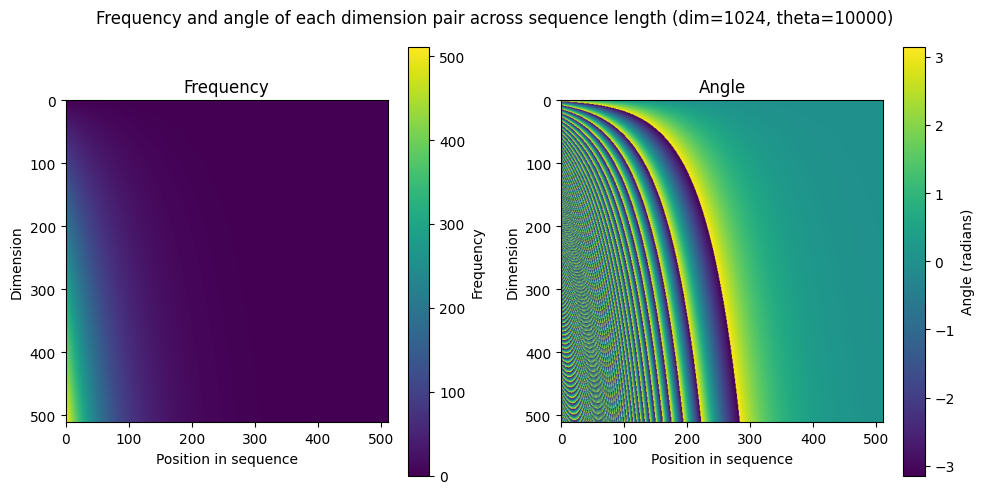

In [115]:
# plot heatmap of the freqs_cis for a given dim and theta
dim = 1024
theta = 10000
seq_len = 512
abs_freqs = compute_freqs(dim, seq_len, theta)
# convert freqs (which are floatsrange from [0, inf) into actual angles in radians [-pi, pi]
# i.e. we want to map [0, inf) -> [-pi, pi]
mod_freqs = convert_freqs_to_angles(abs_freqs)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(abs_freqs, cmap="viridis")
ax[0].set_title("Frequency")
ax[0].set_xlabel("Position in sequence")
ax[0].set_ylabel("Dimension")

# add a colorbar
cbar = fig.colorbar(ax[0].imshow(abs_freqs, cmap="viridis"), ax=ax[0])
cbar.set_label("Frequency")

# add a colorbar
ax[1].imshow(mod_freqs, cmap="viridis")
ax[1].set_title("Angle")
ax[1].set_xlabel("Position in sequence")
ax[1].set_ylabel("Dimension")
# add a colorbar
cbar = fig.colorbar(ax[1].imshow(mod_freqs, cmap="viridis"), ax=ax[1])
cbar.set_label("Angle (radians)")

fig.suptitle(
    f"Frequency and angle of each dimension pair across sequence length (dim={dim}, theta={theta})"
)
fig.tight_layout()
plt.show()


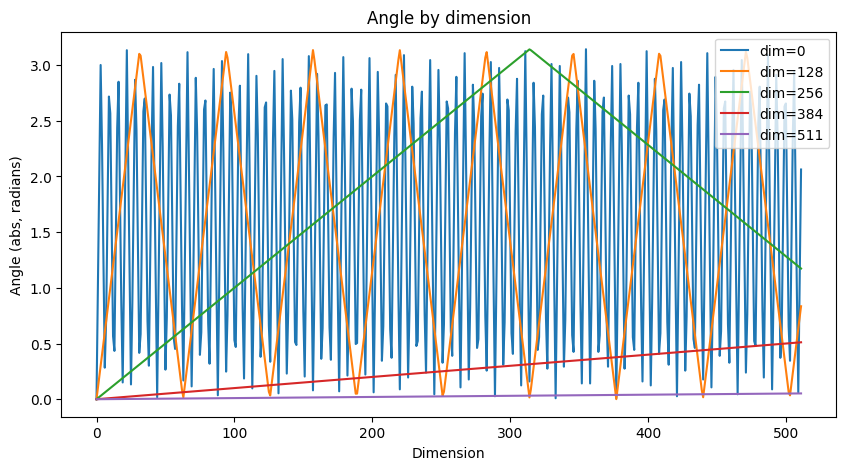

In [ ]:
dim = 1024
theta = 10000
seq_len = 512
abs_freqs = compute_freqs(dim, seq_len, theta)
mod_freqs = convert_freqs_to_angles(abs_freqs).abs()

# plot angles by dimension as lines
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

xs = torch.arange(seq_len)
n_dims_to_show = 4
d_interval = (dim // 2) // n_dims_to_show
for d_idx in range(n_dims_to_show + 1):
    d = min(d_idx * d_interval, dim // 2 - 1)
    ys = mod_freqs[:, d]
    ax.plot(xs, ys, label=f"dim={d}")

ax.set_title("Angle by dimension")
ax.set_xlabel("Dimension")
ax.set_ylabel("Angle (abs, radians)")
ax.legend()
plt.show()


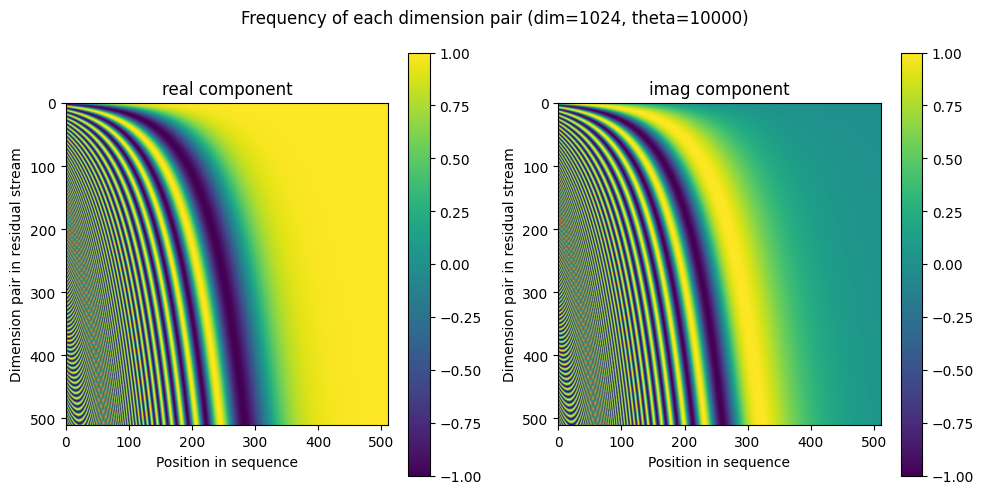

In [33]:
# plot the real component of the freqs_cis
dim = 1024
theta = 10000
seq_len = 512

freqs_cis = precompute_freqs_cis(dim, seq_len, theta)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, (x, values) in zip(axs, [("real", freqs_cis.real), ("imag", freqs_cis.imag)]):
    ax.imshow(values, cmap="viridis")
    ax.set_title(f"{x} component")
    ax.set_xlabel("Position in sequence")
    ax.set_ylabel("Dimension pair in residual stream")
    cbar = fig.colorbar(ax.imshow(values, cmap="viridis"), ax=ax)

fig.suptitle(f"Frequency of each dimension pair (dim={dim}, theta={theta})")
fig.tight_layout()
plt.show()

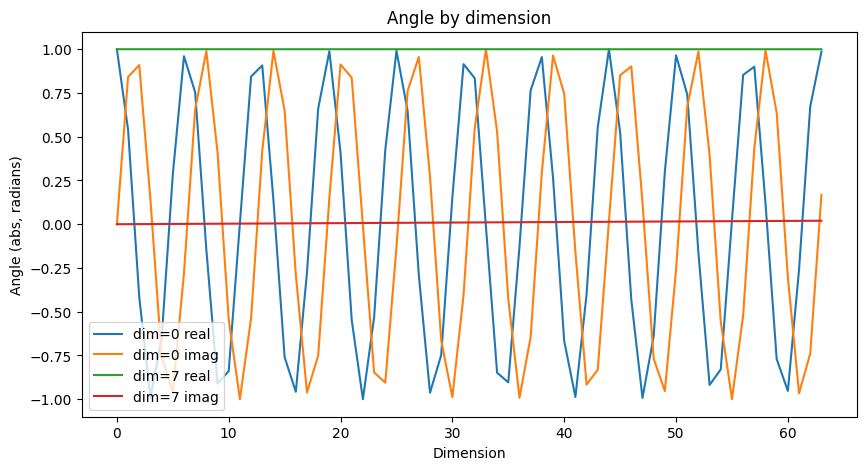

In [120]:
# Plot the real and imaginary components of the freqs_cis in a line plot
dim = 16
theta = 10000
seq_len = 64
freqs_cis = precompute_freqs_cis(dim, seq_len, theta)

# plot angles by dimension as lines
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

xs = torch.arange(seq_len)
n_dims_to_show = 1
d_interval = (dim // 2) // n_dims_to_show
for d_idx in range(n_dims_to_show + 1):
    d = min(d_idx * d_interval, dim // 2 - 1)
    ys = freqs_cis[:, d]
    ax.plot(xs, ys.real, label=f"dim={d} real")
    ax.plot(xs, ys.imag, label=f"dim={d} imag")

ax.set_title("Angle by dimension")
ax.set_xlabel("Dimension")
ax.set_ylabel("Angle (abs, radians)")
ax.legend()
plt.show()

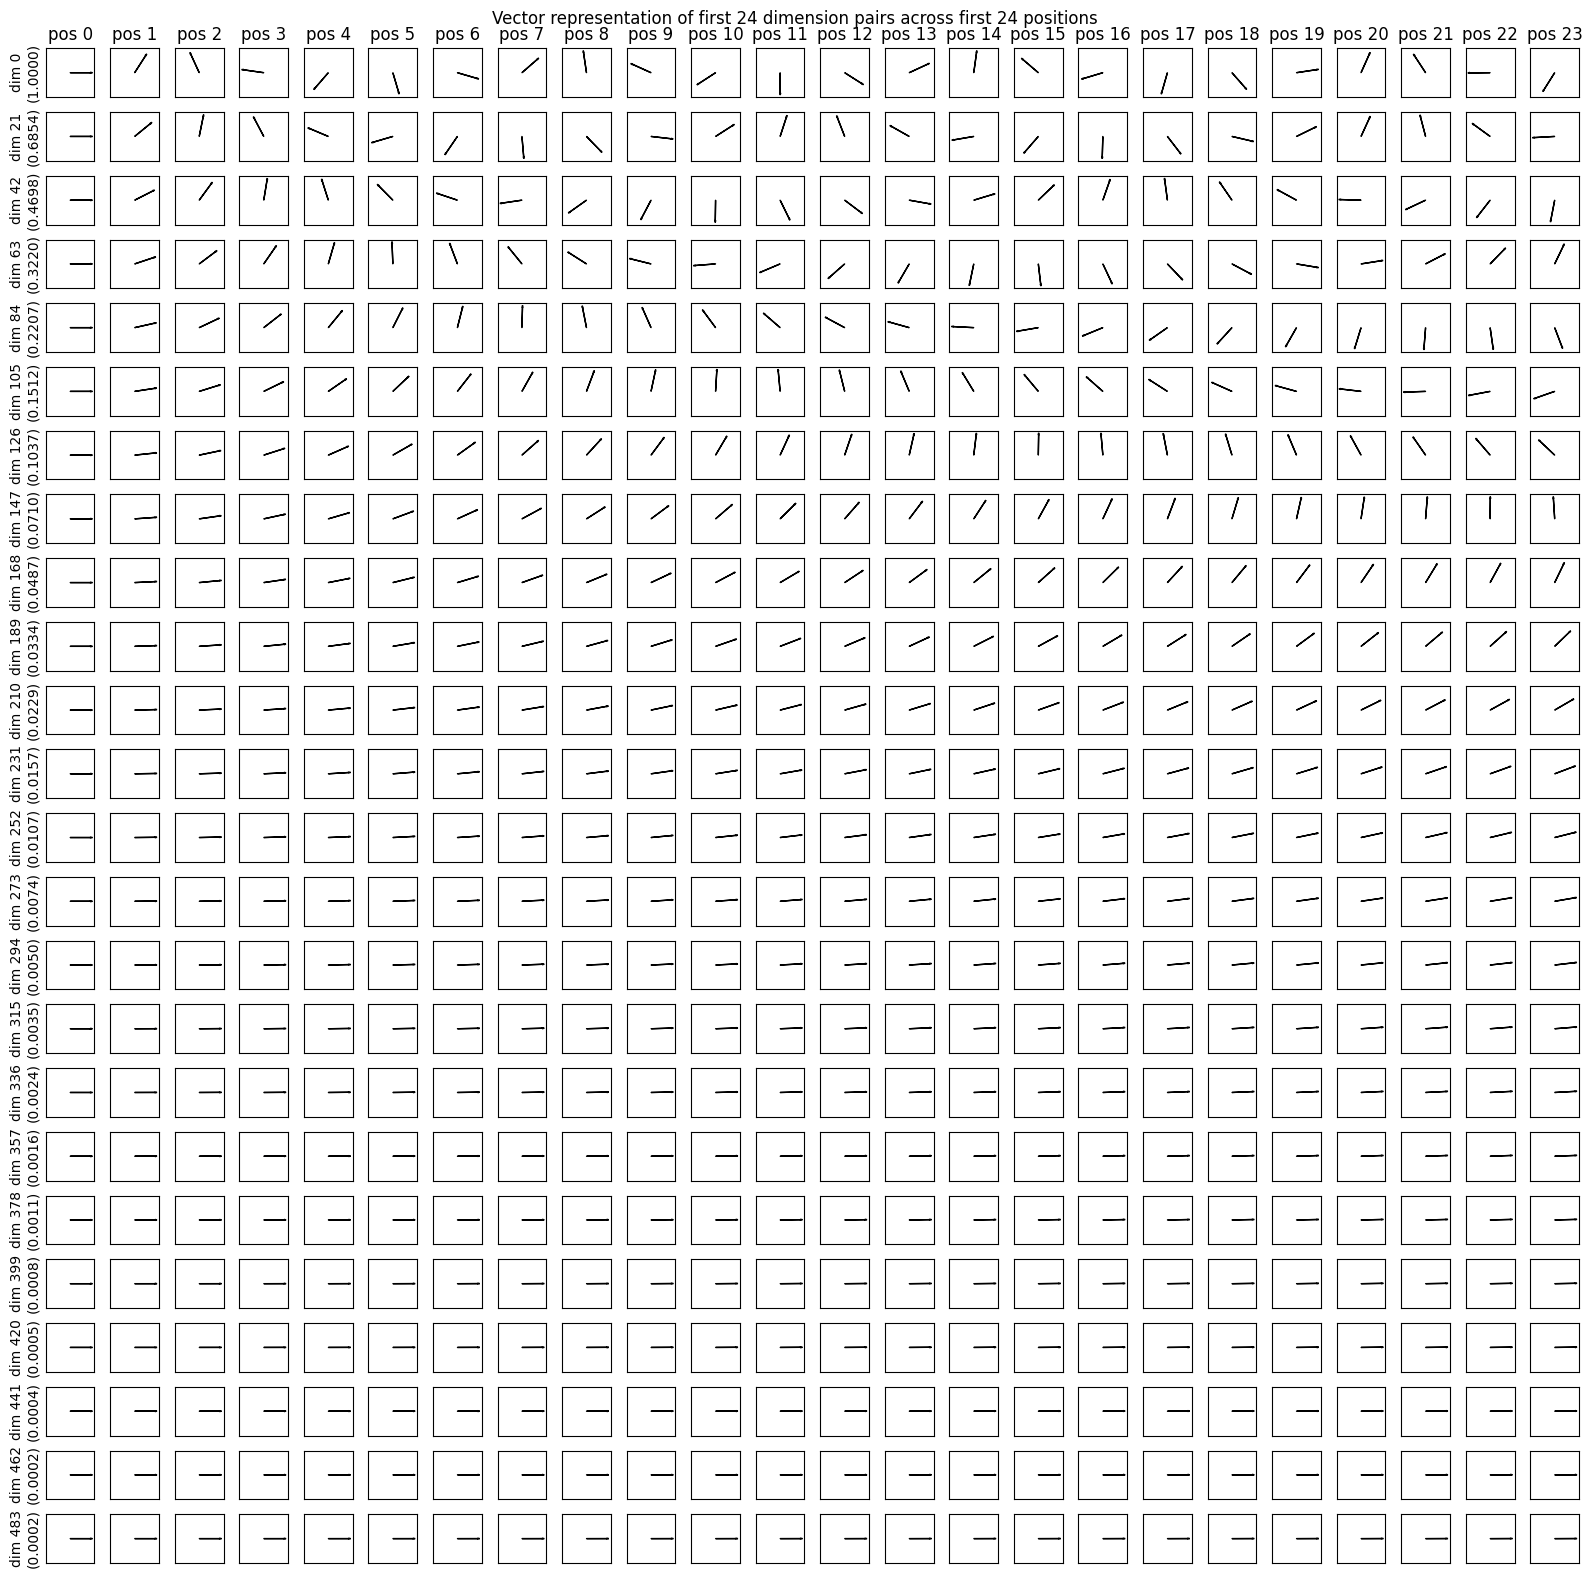

In [34]:
# plot a matrix of vectors where each row is the dimension pair (d, d+1) and each column is the position in the sequence
# by "matrix of vectors" I mean that each cell (d, t) literally shows a vector as an arrow going from the origin to the point
dim = 1024
theta = 10000
seq_len = 512
dim_freqs = compute_dim_freqs(dim, theta)
freqs_cis = precompute_freqs_cis(dim, seq_len, theta)

# create a figure with a grid of subplots, one for each dimension pair
# we'll just show the first few dimension pairs and positions for clarity
n_dims_to_show = 24
n_pos_to_show = 24

fig, axs = plt.subplots(n_dims_to_show, n_pos_to_show, figsize=(16, 16))
fig.suptitle(
    f"Vector representation of first {n_dims_to_show} dimension pairs across first {n_pos_to_show} positions"
)

# for each dimension pair and position
d_interval = (dim // 2) // n_dims_to_show
t_interval = 1
for d in range(n_dims_to_show):
    d_idx = d * d_interval
    for t in range(n_pos_to_show):
        t_idx = t * t_interval
        ax = axs[d, t]
        # get the complex number for this dimension pair and position
        z = freqs_cis[t_idx, d_idx]
        # plot vector from origin to point
        ax.arrow(0, 0, z.real, z.imag, head_width=0.05, head_length=0.1)
        # set equal aspect ratio and limits
        ax.set_aspect("equal")
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        # add grid
        ax.grid(True)
        # remove ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

        # add labels only for first row and column
        if d == 0:
            ax.set_title(f"pos {t_idx}")
        if t == 0:
            dim_freq = dim_freqs[d_idx]
            ax.set_ylabel(f"dim {d_idx}\n({dim_freq:.4f})")

plt.tight_layout()
plt.show()


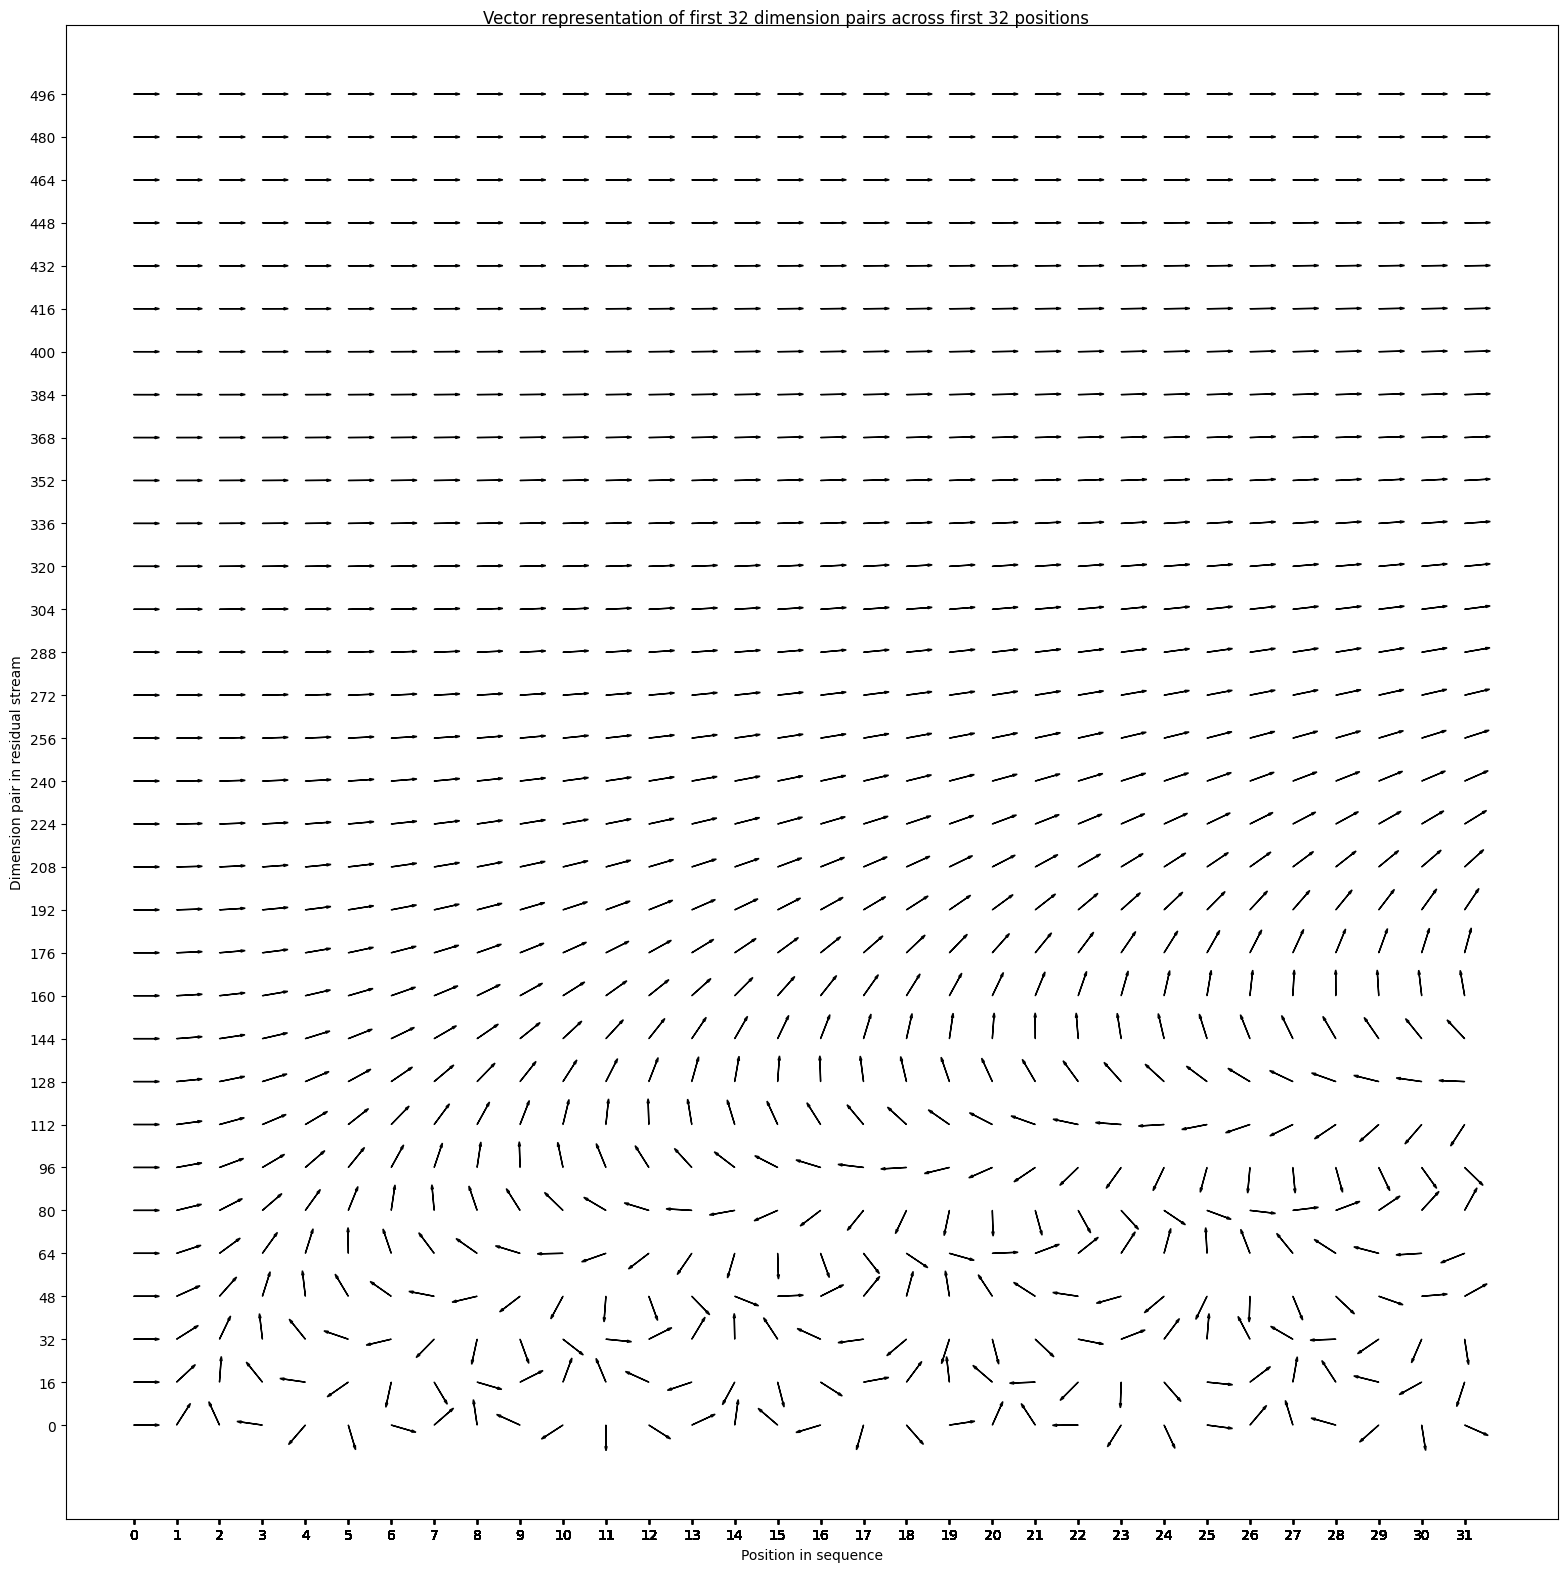

In [65]:
# plot a matrix of vectors where each row is the dimension pair (d, d+1) and each column is the position in the sequence
# by "matrix of vectors" I mean that each cell (d, t) literally shows a vector as an arrow going from the origin to the point
dim = 1024
theta = 10000
seq_len = 512
dim_freqs = compute_dim_freqs(dim, theta)
freqs_cis = precompute_freqs_cis(dim, seq_len, theta)

# create a figure with a grid of subplots, one for each dimension pair
# we'll just show the first few dimension pairs and positions for clarity
n_dims_to_show = 32
n_pos_to_show = 32

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.suptitle(
    f"Vector representation of first {n_dims_to_show} dimension pairs across first {n_pos_to_show} positions"
)


# for each dimension pair and position
d_interval = (dim // 2) // n_dims_to_show
t_interval = 1
x_ticks = ([], [])
y_ticks = ([], [])
for d_idx in range(n_dims_to_show):
    d = d_idx * d_interval
    y_ticks[0].append(d_idx)
    y_ticks[1].append(d)
    for t_idx in range(n_pos_to_show):
        t = t_idx * t_interval
        # get the complex number for this dimension pair and position
        z = freqs_cis[t, d]
        # plot vector from origin to point (where origin is shited based on dim and pos)
        ax.arrow(
            t_idx,
            d_idx,
            float(z.real) * 0.5,  # scale down the vector to fit in the grid
            float(z.imag) * 0.5,  # scale down the vector to fit in the grid
            head_width=0.05,
            head_length=0.1,
        )
        x_ticks[0].append(t_idx)
        x_ticks[1].append(t)


# set equal aspect ratio and limits
ax.set_aspect("equal")
ax.set_xticks(x_ticks[0], x_ticks[1])
ax.set_yticks(y_ticks[0], y_ticks[1])
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Dimension pair in residual stream")

plt.tight_layout()
plt.show()

## How do polar coordinates and complex numbers relate to each other and what does this have to do with encoding positional information?

### Polar coordinates

A polar coordinate represents a point or vector in a 2D plane via two components:

- $r$: the radius, which is the distance from the origin to the point
- $\theta$: the angle, which is the angle between the positive x-axis and the line connecting the origin to the point

The aim of RoPE is to encode positional information by varying the angle $\theta$ that we rotate a given vector, and so for our purposes radius $r$ is always 1 (i.e. we want to change the angle of another vector but keep it's length unchanged).

For RoPE we pre-compute an angle $\theta$ (aka frequency) for a given dimension-pair $(d, d+1)$ and position $t$. Then given a vector $x$ (i.e. the Query or Key head activations of an attention block in our transformer model) we want to rotate the 2D sub-vector $[x_d, x_{d+1}]$ by the angle $\theta$ to get a new vector $(x_d', x_{d+1}')$. By having the angle of rotation $\theta$ depend on the dimension and psoition, this encodes positional information about the position $t$ that $x$ is at in the sequence.

Now to do this rotation, we can use a rotation matrix:

```python
def rotate_vector_via_rotation_matrix(v, theta):
    # convert theta into 2D rotation matrix
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)

    rotation_matrix = torch.tensor([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])
    # apply rotation matrix to vector
    return rotation_matrix @ v
```

Now this is all well and good, but remember this is to rotate only 2 dimensions of a vector $x$ at a single position $t$ in the sequence. Both the size of $x$ and the sequence length are in the thousands for any practical transformer model. 

Wouldn't it be nice if there was a way to represent this operation as a single matrix multiplication? Enter complex numbers!

### Complex numbers

Complex numbers provide a convenient way to perform 2D vector rotations.

Like polar coorinates complex numbers are also defined via two components:

- $a$: the real part
- $b$: the imaginary part

We can use this fact to conveniently represent a 2D vector as a single complex number. And torch even provides convenient functions to do just this:

```python
# represent polar coordinate as complex number
theta = torch.tensor(torch.pi / 2)
z = torch.polar(torch.tensor(1.0), theta)
# z.real = 0.0   (x)
# z.imag = 1.0   (y)
```

The great thing about representing  (TODO I'm here finish working thru this, basically we can reduce our operation to a single matrix multiplication between two complex number matrices)




**Questions**

- How does the varying angle $\theta$ encode positional information?



/var/folders/13/dzgg72s13tq3_tr95mms56640000gn/T/ipykernel_53436/1316571261.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta_idx)


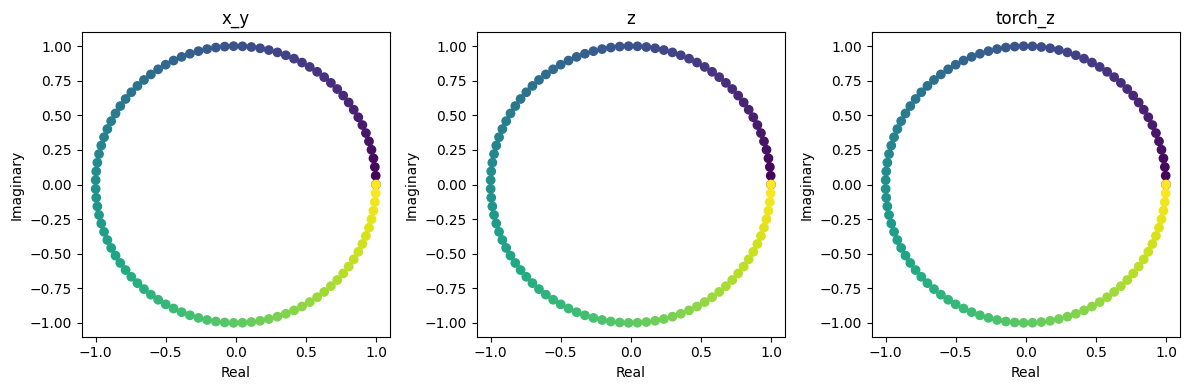

In [35]:
# varifying wtf toch.polar does
# x = 90 deg = pi / 2 radians
r = torch.tensor(1.0)
x_y = []
zs = []
torch_z = []

n_points = 100
interval = 2 * torch.pi / n_points
thetas = torch.linspace(0, 2 * torch.pi, n_points)
for theta_idx in thetas:
    theta = torch.tensor(theta_idx)

    # calculate the cartesian coordinates manually
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    x_y.append(torch.tensor([x, y]))
    # conver to complex number manually
    z = r * (torch.cos(theta) + torch.sin(theta) * 1j)
    zs.append(z)
    # convert to complex number via torch.polar
    torch_polar = torch.polar(r, theta)
    torch_z.append(torch_polar)


normalize = mcolors.Normalize(vmin=0, vmax=len(x_y))
colormap = cm.jet

# plot each collection of vectors in its own subplot
# with color corresponding to position in vector sequence
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, (vectors, label) in zip(axs, [(x_y, "x_y"), (zs, "z"), (torch_z, "torch_z")]):
    if label == "x_y":
        xs = [m[0] for m in vectors]
        ys = [m[1] for m in vectors]
    else:
        xs = [m.real for m in vectors]
        ys = [m.imag for m in vectors]
    colors = [normalize(i) for i in range(len(xs))]
    ax.scatter(xs, ys, label=label, c=colors)
    ax.set_title(label)
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")

fig.tight_layout()


In [81]:
# Define rotation angle
theta = np.pi / 4  # 45 degrees

# Method 1: Complex number
complex_rotation = np.exp(1j * theta)

# Method 2: Rotation matrix
rotation_matrix = np.array(
    [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
)

# Let's rotate a vector [1, 0]
vector = np.array([1, 0])

# Using complex numbers
complex_vector = 1 + 0j  # representing [1, 0]
rotated_complex = complex_rotation * complex_vector
print(f"Complex rotation result: {rotated_complex}")
# Will be approximately 0.707 + 0.707j

# Using matrix
rotated_matrix = rotation_matrix @ vector
print(f"Matrix rotation result: {rotated_matrix}")
# Will be approximately [0.707, 0.707]


Complex rotation result: (0.7071067811865476+0.7071067811865475j)
Matrix rotation result: [0.70710678 0.70710678]


## Visualizing the effect of RoPE on a vector

Here we'll try to visualize what happens to the a vector $x$ when we apply RoPE to it.

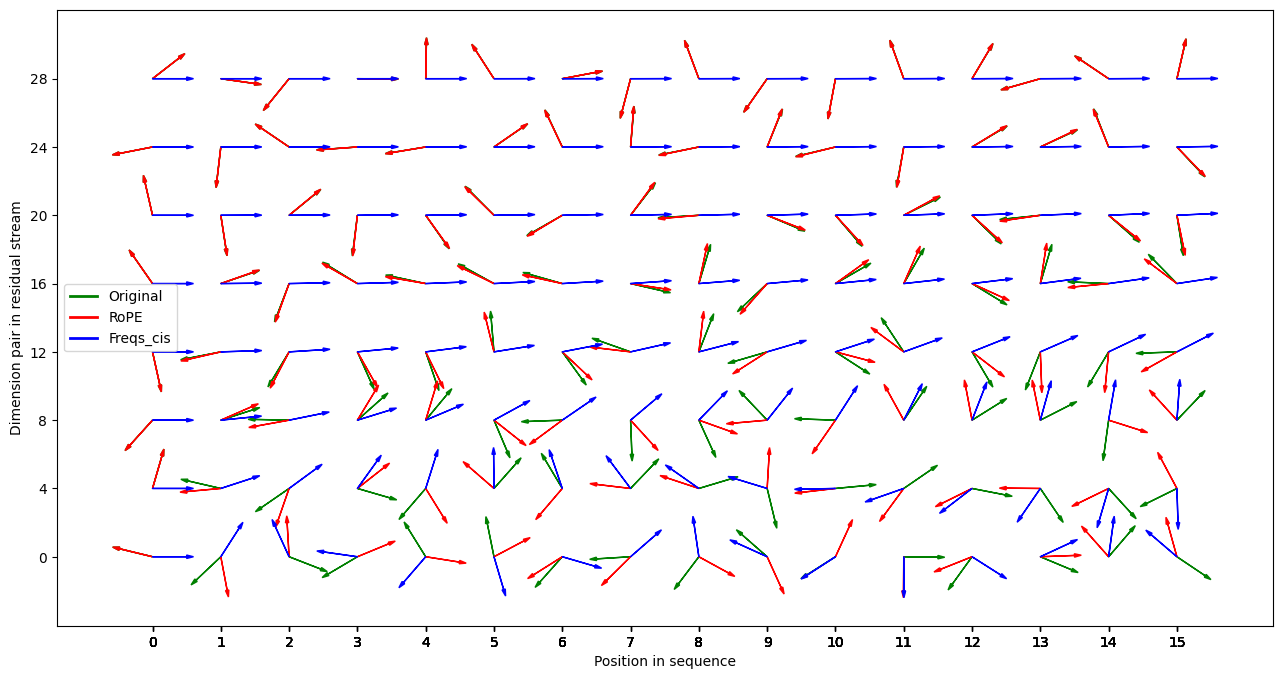

In [ ]:
from matplotlib.lines import Line2D


def get_origin(d, d_max, d_interval, t, t_max, t_interval):
    return d * d_interval, t * t_interval


def plot_as_individual_vectors(
    ax, y: torch.Tensor, n_dims_to_show, n_pos_to_show, color: str
):
    T, D = y.shape
    # for each dimension pair and position
    d_interval = D // n_dims_to_show
    t_interval = T // n_pos_to_show
    x_ticks = ([], [])
    y_ticks = ([], [])
    for d_idx in range(n_dims_to_show):
        d = d_idx * d_interval
        y_ticks[0].append(d_idx)
        y_ticks[1].append(d)
        for t_idx in range(n_pos_to_show):
            t = t_idx * t_interval
            # get the complex number for this dimension pair and position
            z = y[t, d]
            # plot vector from origin to point (where origin is shited based on dim and pos)

            # normalize z to unit length
            z = z / z.norm()

            ax.arrow(
                t_idx,
                d_idx,
                float(z.real) * 0.5,  # scale down the vector to fit in the grid
                float(z.imag) * 0.5,  # scale down the vector to fit in the grid
                head_width=0.05,
                head_length=0.1,
                color=color,
            )
            x_ticks[0].append(t_idx)
            x_ticks[1].append(t)

    # set equal aspect ratio and limits
    ax.set_aspect("equal")
    ax.set_xticks(x_ticks[0], x_ticks[1])
    ax.set_yticks(y_ticks[0], y_ticks[1])


# Plot the freqs_cis for various dim sizes for a given sequence length
dim = 64
theta = 10000
seq_len = 16
freqs_cis = precompute_freqs_cis(dim, seq_len, theta)

n_dims_to_show = 8
n_pos_to_show = 16

x = torch.randn(seq_len, dim)
# normalize x to unit length
x_complex = torch.view_as_complex(x.reshape(seq_len, dim // 2, 2))

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

plot_as_individual_vectors(ax, x_complex, n_dims_to_show, n_pos_to_show, color="green")

x_rope_complex = apply_rotary_emb_to_vector_as_complex(x, freqs_cis)
plot_as_individual_vectors(
    ax, x_rope_complex, n_dims_to_show, n_pos_to_show, color="red"
)

plot_as_individual_vectors(ax, freqs_cis, n_dims_to_show, n_pos_to_show, color="blue")

assert x_complex.shape == x_rope_complex.shape
assert x_complex.shape == freqs_cis.shape

# add custom legend
ax.legend(
    [
        Line2D([0], [0], color="green", lw=2),
        Line2D([0], [0], color="red", lw=2),
        Line2D([0], [0], color="blue", lw=2),
    ],
    ["Original", "RoPE", "Freqs_cis"],
)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Dimension pair in residual stream")

plt.show()
